In [14]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
from torch.utils import data
from torch.utils.data import TensorDataset, DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
import pickle

def getData(mode):
    if mode == 'train':
        df = pd.read_csv('train.csv')
        path = df['Path'].tolist()
        label = df['label'].tolist()
        return path, label
    
    elif mode == 'valid':
        df = pd.read_csv('valid.csv')
        path = df['Path'].tolist()
        label = df['label'].tolist()
        return path, label
    
    else:
        df = pd.read_csv('resnet_18_test.csv')
        path = df['Path'].tolist()
        return path

class RetinopathyLoader(data.Dataset):
    def __init__(self, root, mode):
        """
        Args:
            root (string): Root path of the dataset.
            mode : Indicate procedure status(training or testing)

            self.img_name (string list): String list that store all image names.
            self.label (int or float list): Numerical list that store all ground truth label values.
        """
        self.root = root
        self.mode = mode
        
        if mode == 'train' or mode == 'valid':
            self.img_name, self.label = getData(mode)
        else:  # mode == 'test'
            self.img_name = getData(mode)
            self.label = None  # No labels for test data
            
        # print("> Found %d images..." % (len(self.img_name)))

    def __len__(self):
        """'return the size of dataset"""
        return len(self.img_name)

    def __getitem__(self, index):

        """
           step1. Get the image path from 'self.img_name' and load it.
                  hint : path = root + self.img_name[index] + '.jpeg'

           step2. Get the ground truth label from self.label

           step3. Transform the .jpeg rgb images during the training phase, such as resizing, random flipping, 
                  rotation, cropping, normalization etc. But at the beginning, I suggest you follow the hints. 

                  In the testing phase, if you have a normalization process during the training phase, you only need 
                  to normalize the data. 

                  hints : Convert the pixel value to [0, 1]
                          Transpose the image shape from [H, W, C] to [C, H, W]

            step4. Return processed image and label
        """

        img_path = os.path.join(self.root, self.img_name[index]) # + '.jpeg'
        img = Image.open(img_path)
        
        if self.mode == 'train':
            transform=transforms.Compose([
                transforms.CenterCrop(410), # crops the center region of the image with a square size of height
                # transforms.Resize(300), # (h, w) 512x512 pixels
                transforms.RandomHorizontalFlip(), #  randomly flips the image horizontally with a 50% chance
                transforms.RandomRotation(degrees=15), # randomly rotates the image by a maximum of 15 degree
                transforms.ToTensor(),
                transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
                # Add an additional transformation to rescale pixel values to [0, 1]
                # transforms.Lambda(lambda x: (x + 1.0) / 2.0)
            ])
        elif self.mode == 'valid':
            transform=transforms.Compose([
                transforms.CenterCrop(410),
                # transforms.Resize(300),
                transforms.ToTensor(),
                transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
                # Add an additional transformation to rescale pixel values to [0, 1]
                # transforms.Lambda(lambda x: (x + 1.0) / 2.0)
            ])
        else:
            transform = transforms.Compose([
                transforms.CenterCrop(410),
                transforms.ToTensor(),
                transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            ])
        
        img = transform(img) 
        
        # print(img[0].shape)
        
        if self.label is not None:
            label = self.label[index]
            return img, label
        else:
            return img

In [15]:
torch.manual_seed(514)

batch_size = 32

train_dataset = RetinopathyLoader(root = ".", mode="train")
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

valid_dataset = RetinopathyLoader(root = ".", mode="valid")
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

test_dataset = RetinopathyLoader(root = ".", mode="test")
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# train_cnt = len(train_loader.dataset)
# print(train_cnt) # 7995

# valid_cnt = len(valid_loader.dataset)
# valid_cnt # 1599

test_cnt = len(test_loader.dataset)
test_cnt # 1067

1067

In [16]:
def get_device():
    return 'cuda' if torch.cuda.is_available() else 'cpu'

device = get_device()
device

'cuda'

In [17]:
class BottleneckBlock(nn.Module):
    def __init__(self, prev_channel, in_channel, out_channel, stride=(1, 1), downsample=False):
        super().__init__()
                
        # First bottleneck block needs to be downsampled
        if downsample: 
            self.conv = nn.Sequential(
                nn.Conv2d(prev_channel, out_channel, kernel_size=(1, 1), stride=(1, 1), bias=False),
                nn.BatchNorm2d(out_channel, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                nn.Conv2d(out_channel, out_channel, kernel_size=(3, 3), stride=stride, padding=(1, 1), bias=False),
                nn.BatchNorm2d(out_channel, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                nn.Conv2d(out_channel, in_channel, kernel_size=(1, 1), stride=(1, 1), bias=False),
                nn.BatchNorm2d(in_channel, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            )
            self.down_sample = nn.Sequential(
                nn.Conv2d(prev_channel, in_channel, kernel_size=(1,1), stride=stride, bias=False),
                nn.BatchNorm2d(in_channel)
            )
        else:
            self.conv = nn.Sequential(
                nn.Conv2d(in_channel, out_channel, kernel_size=(1, 1), stride=(1, 1), bias=False),
                nn.BatchNorm2d(out_channel, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                nn.Conv2d(out_channel, out_channel, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
                nn.BatchNorm2d(out_channel, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                nn.Conv2d(out_channel, in_channel, kernel_size=(1, 1), stride=(1, 1), bias=False),
                nn.BatchNorm2d(in_channel, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            )
            self.down_sample = nn.Identity()
            
        self.ReLU = nn.ReLU(inplace=True)
        
    def forward(self, x):
        out = self.conv(x)
        residual = self.down_sample(x)
        out = self.ReLU(out + residual)
        return out

def add_bottleneck_blocks(prev_channel, in_channel, out_channel, stride, num_blocks):
    bottleneck_blocks = []
    bottleneck_blocks.append(BottleneckBlock(prev_channel, in_channel, out_channel, stride, True))
    for _ in range(num_blocks-1):
        bottleneck_blocks.append(BottleneckBlock(prev_channel, in_channel, out_channel))
    return bottleneck_blocks

class ResNet152(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True,),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=1, ceil_mode=False),
        )
        
        # Each layer has ($num_blocks) bottleneck blocks
        self.layer1 = nn.Sequential(*add_bottleneck_blocks(64, 256, 64, (1, 1), num_blocks=3))
        self.layer2 = nn.Sequential(*add_bottleneck_blocks(256, 512, 128, (2, 2), num_blocks=8)) 
        self.layer3 = nn.Sequential(*add_bottleneck_blocks(512, 1024, 256, (2, 2), num_blocks=36))
        self.layer4 = nn.Sequential(*add_bottleneck_blocks(1024, 2048, 512, (2, 2), num_blocks=3))

        # self.avg_pool = nn.AvgPool2d(kernal_size=7, stride=1, padding=0)
        self.avg_pool = nn.AdaptiveAvgPool2d(output_size=(1, 1)) # (output_H, output_W)
        self.fc = nn.Linear(2048, 2)

    def forward(self, x):
        output = self.conv1(x)
        output = self.layer1(output)
        output = self.layer2(output)
        output = self.layer3(output)
        output = self.layer4(output)              # print(output.shape) (num, 512, n, n)
        output = self.avg_pool(output)            # print(output.shape) (num, 512, 1, 1)
        # out = nn.flatten(out)
        output = output.view(output.shape[0], -1) # print(output.shape) (num, 512)
        output = self.fc(output)                  # print(output.shape) (num, 2)
        return output

In [5]:
def epoch_loop(cur_epoch, num_epoch, remaining_epoch, train_loader, test_loader, model, loss_fn, optimizer, train_acc_list, valid_acc_list):
    best_acc = 0
    for e in range(1, remaining_epoch+1):
        global predicted_list
        predicted_list = []
        train_acc = train(train_loader, model, loss_fn, optimizer, train_acc_list)
        valid_acc = valid(valid_loader, model, loss_fn, valid_acc_list)
        if (e % (1 if (num_epoch // 10) == 0 else (num_epoch // 10))) == 0:
            print(f'Epoch: {cur_epoch+e:5}, train_acc:{train_acc:.2f}%')
            print(f'Epoch: {cur_epoch+e:5}, valid_acc:{valid_acc:.2f}%')
        if valid_acc > best_acc:
            global predicted_label
            predicted_label = predicted_list
            best_acc = valid_acc
            file_name = "ResNet152_"+str(optimizer.__class__.__name__)+".pth"
            file_folder = "models/ResNet152"
            file_path = os.path.join(file_folder, file_name)
            torch.save(model.state_dict(), file_path)
            
            with open('models/ResNet152/train_state.pkl', 'wb') as f:
                pickle.dump({
                    'num_epoch': num_epoch,
                    'cur_epoch': cur_epoch + e,
                    'remaining_epoch': num_epoch - (cur_epoch + e),
                    'loss_fn': loss_fn,
                    
                    'train_acc_list': train_acc_list,
                    'valid_acc_list': valid_acc_list,
                    'predicted_list': predicted_list,
                    'predicted_label': predicted_label,
                    'test_predicted_label': test_predicted_label,
                    
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict()
                }, f)
        if (e == remaining_epoch or e % (1 if (num_epoch // 10) == 0 else (num_epoch // 10)))==0:
            print(f'best acc: {best_acc:.2f}%')
            with open('models/ResNet152/train_state.pkl', 'wb') as f:
                pickle.dump({
                    'num_epoch': num_epoch,
                    'cur_epoch': cur_epoch + e,
                    'remaining_epoch': num_epoch - (cur_epoch + e),
                    'loss_fn': loss_fn,
                    
                    'train_acc_list': train_acc_list,
                    'valid_acc_list': valid_acc_list,
                    'predicted_list': predicted_list,
                    'predicted_label': predicted_label,
                    'test_predicted_label': test_predicted_label,
                    
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict()
                }, f)
            
def train(train_loader, model, loss_fn, optimizer, train_acc_list):
    model.train() 
    match_train_cnt = 0
    total_cnt = len(train_loader.dataset)
    
    for i, (train_data, train_label) in enumerate(train_loader):
        train_data = train_data.to(device)
        train_label = train_label.to(device).to(torch.long)

        output = model(train_data)
        loss = loss_fn(output, train_label)

        pred = torch.max(output, dim=1) 
        match_train_cnt += (pred[1] == train_label).sum().item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    acc = match_train_cnt / total_cnt * 100
    train_acc_list.append(acc)
    return acc
        
def valid(valid_loader, model, loss_fn, valid_acc_list):
    # Step 5: Testing loop
    model.eval()
    match_valid_cnt = 0
    total_cnt = len(valid_loader.dataset)
    
    with torch.no_grad():
        for i, (valid_data, valid_label) in enumerate(valid_loader):   
            valid_data = valid_data.to(device)
            valid_label = valid_label.to(device).to(torch.long)
            output = model(valid_data)
            pred = torch.max(output, dim=1)
            match_valid_cnt += (pred[1] == valid_label).sum().item()
            
            # Convert the ground truth labels and predicted labels to NumPy arrays and 
            # Retrieve the indices corresponding to their maximum values
            # true_label.extend(valid_label.cpu().data.numpy())
            predicted_list.append(pred[1].cpu().data.numpy())

    acc = match_valid_cnt / total_cnt * 100
    valid_acc_list.append(acc)
    return acc

def test(test_loader, model):
    model.eval()
    with torch.no_grad():
        for i, test_data in enumerate(test_loader):
            test_data = test_data.to(device)
            output = model(test_data)
            pred = torch.max(output, dim=1)
            test_predicted_label.append(pred[1].cpu().data.numpy())

In [18]:
def show_result():
    best_train_acc = 0
    best_valid_acc = 0
    for i in range(num_epoch):
        best_train_acc = max(best_train_acc, train_acc_list[i])
        best_valid_acc = max(best_valid_acc, valid_acc_list[i])
    
    plt.title('Accuracy Curve(ResNet152)')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy(%)')

    plt.plot(train_acc_list, label = 'ResNet152_train', color = 'b')
    plt.plot(valid_acc_list, label = 'ResNet152_valid', color = 'r')
    
    plt.legend()
    plt.show()
    
    print(f'Best train acc: {best_train_acc:.2f}%, Best valid acc: {best_valid_acc:.2f}%')

In [19]:
def plot_confusion_matrix(true_label, predicted_label, classes, normalize = False, title = None, cmap = plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    # Compute confusion matrix
    cm = confusion_matrix(true_label, predicted_label)
    
    # Calculate class-wise accuracy if normalization is enabled
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(6, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

In [8]:
train_acc_list = []
valid_acc_list = []
predicted_list = []
predicted_label = []
test_predicted_label = []

In [9]:
# Training step

cur_epoch = 0
num_epoch = 21
remaining_epoch = num_epoch - cur_epoch

model = ResNet152().to(device)
loss_fn = nn.CrossEntropyLoss().to(device)

# optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, weight_decay=5e-4, momentum=0.9)
epoch_loop(cur_epoch, num_epoch, remaining_epoch, train_loader, valid_loader, model, loss_fn, optimizer, train_acc_list, valid_acc_list)

Epoch:     2, train_acc:84.02%
Epoch:     2, valid_acc:68.29%
best acc: 80.30%
Epoch:     4, train_acc:87.92%
Epoch:     4, valid_acc:85.05%
best acc: 85.05%
Epoch:     6, train_acc:89.23%
Epoch:     6, valid_acc:78.99%
best acc: 85.05%
Epoch:     8, train_acc:90.03%
Epoch:     8, valid_acc:88.56%
best acc: 88.56%
Epoch:    10, train_acc:90.18%
Epoch:    10, valid_acc:80.55%
best acc: 88.56%
Epoch:    12, train_acc:91.53%
Epoch:    12, valid_acc:89.56%
best acc: 89.56%
Epoch:    14, train_acc:91.86%
Epoch:    14, valid_acc:49.78%
best acc: 89.56%
Epoch:    16, train_acc:91.61%
Epoch:    16, valid_acc:76.86%
best acc: 89.56%
Epoch:    18, train_acc:92.60%
Epoch:    18, valid_acc:82.30%
best acc: 89.56%
Epoch:    20, train_acc:92.33%
Epoch:    20, valid_acc:72.48%
best acc: 89.56%


In [10]:
# Continue training from previous interrupted training
# Or you can train more epochs by revising num_epoch

with open('models/ResNet152/train_state.pkl', 'rb') as f:
    train_state = pickle.load(f)
    
cur_epoch = train_state['cur_epoch']
num_epoch = train_state['num_epoch']
# num_epoch = 301
# remaining_epoch = train_state['remaining_epoch']
remaining_epoch = num_epoch - cur_epoch
loss_fn = train_state['loss_fn']

if remaining_epoch > 0:
    print(f'Current epoch: {cur_epoch}, Remaining epoch: {remaining_epoch}')

    train_acc_list = train_state['train_acc_list']
    valid_acc_list = train_state['valid_acc_list']
    predicted_list = train_state['predicted_list']
    predicted_label = train_state['predicted_label']
    test_predicted_label = train_state['test_predicted_label']

    model_state_dict = train_state['model_state_dict']
    optimizer_state_dict = train_state['optimizer_state_dict']

    model = ResNet152().to(device)
    model.load_state_dict(model_state_dict)

    optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, weight_decay=5e-4, momentum=0.9)
    optimizer.load_state_dict(optimizer_state_dict)

    epoch_loop(cur_epoch, num_epoch, remaining_epoch, train_loader, valid_loader, model, loss_fn, optimizer, train_acc_list, valid_acc_list)

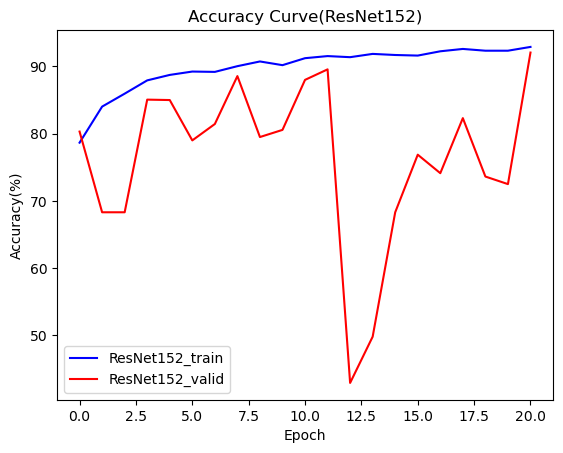

Best train acc: 92.90%, Best valid acc: 92.06%


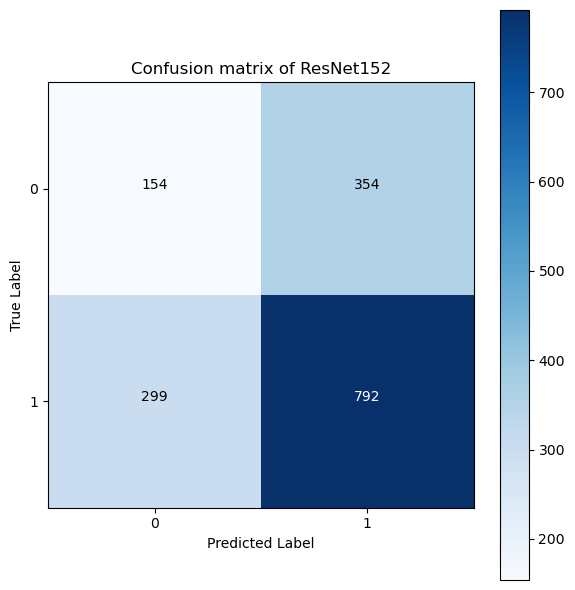

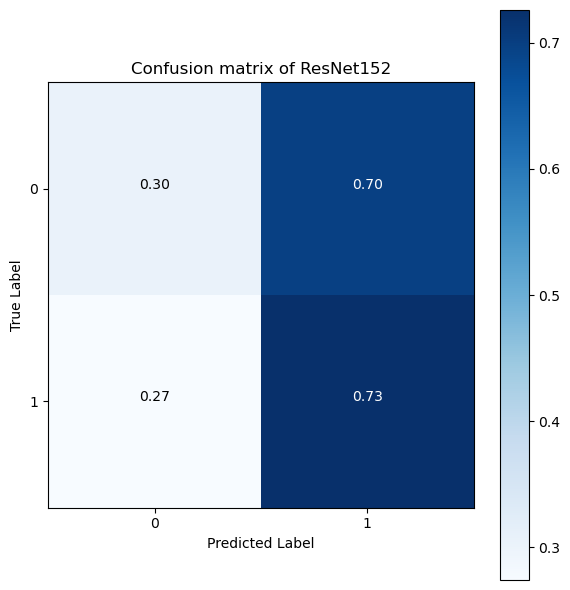

In [20]:
# Demo step: Run cell 1 to 7 and run this to show results on valid data

import pickle

with open('models/ResNet152/train_state.pkl', 'rb') as f:
    train_state = pickle.load(f)

num_epoch = train_state['num_epoch']
loss_fn = train_state['loss_fn']

model_state_dict = train_state['model_state_dict']
optimizer_state_dict = train_state['optimizer_state_dict']

model = ResNet152().to(device)
model.load_state_dict(model_state_dict)

optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, weight_decay=5e-4, momentum=0.9)
optimizer.load_state_dict(optimizer_state_dict)

train_acc_list = train_state['train_acc_list']
valid_acc_list = train_state['valid_acc_list']
predicted_list = train_state['predicted_list']
predicted_label = train_state['predicted_label']
test_predicted_label = train_state['test_predicted_label']

show_result()

_, true_label = getData('valid')
predicted_label = np.concatenate(predicted_label).tolist()
plot_confusion_matrix(true_label, predicted_label, ['0', '1'], title='Confusion matrix of ResNet152')
plot_confusion_matrix(true_label, predicted_label, ['0', '1'], True, title='Confusion matrix of ResNet152')

In [12]:
# Load model and run on test data then write to csv

loss_fn = nn.CrossEntropyLoss().to(device)
model = ResNet152().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, weight_decay=5e-4, momentum=0.9)

file_name = "ResNet152_"+str(optimizer.__class__.__name__)+".pth"
file_folder = "models/ResNet152"
file_path = os.path.join(file_folder, file_name)
model.load_state_dict(torch.load(file_path))

model.eval()
test(test_loader, model)
test_predicted_label = np.concatenate(test_predicted_label).tolist()

# print(test_predicted_label)
# print(len(test_predicted_label))

In [13]:
import pandas as pd

def write_to_csv(image_paths, labels, output_file):
    df = pd.DataFrame({'ID': image_paths, 'label': labels})
    df.to_csv(output_file, index=False)
    
image_paths = getData('test')

labels = test_predicted_label

output_file = "csv/resnet_152_test_SGD.csv"

write_to_csv(image_paths, labels, output_file)